In [72]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import yfinance as yf
from dateutil.relativedelta import relativedelta

### Data Processing

In [2]:
raw = pd.read_csv('data_raw.csv', index_col=False, usecols=['Date','P','CAPE'], skiprows=7)

raw.tail()

,Date,P,CAPE
2451,NaN,NaN,NaN
2452,NaN,NaN,NaN
2453,NaN,NaN,NaN
2454,NaN,NaN,NaN
2455,NaN,NaN,NaN


In [3]:
data = raw.loc[raw['Date'] < 2016].copy()
data.tail()

,Date,P,CAPE
1735,2015.08,2039.87,25.69
1736,2015.09,1944.41,24.50
1737,2015.10,2024.81,25.49
1738,2015.11,2080.62,26.23
1739,2015.12,2054.08,25.97


In [4]:
date_list = raw['Date'].tolist()
shorter_dates = [i for i in date_list if len(str(i)) == 6]
shorter_dates

[1871.1,
 1872.1,
 1873.1,
 1874.1,
 1875.1,
 1876.1,
 1877.1,
 1878.1,
 1879.1,
 1880.1,
 1881.1,
 1882.1,
 1883.1,
 1884.1,
 1885.1,
 1886.1,
 1887.1,
 1888.1,
 1889.1,
 1890.1,
 1891.1,
 1892.1,
 1893.1,
 1894.1,
 1895.1,
 1896.1,
 1897.1,
 1898.1,
 1899.1,
 1900.1,
 1901.1,
 1902.1,
 1903.1,
 1904.1,
 1905.1,
 1906.1,
 1907.1,
 1908.1,
 1909.1,
 1910.1,
 1911.1,
 1912.1,
 1913.1,
 1914.1,
 1915.1,
 1916.1,
 1917.1,
 1918.1,
 1919.1,
 1920.1,
 1921.1,
 1922.1,
 1923.1,
 1924.1,
 1925.1,
 1926.1,
 1927.1,
 1928.1,
 1929.1,
 1930.1,
 1931.1,
 1932.1,
 1933.1,
 1934.1,
 1935.1,
 1936.1,
 1937.1,
 1938.1,
 1939.1,
 1940.1,
 1941.1,
 1942.1,
 1943.1,
 1944.1,
 1945.1,
 1946.1,
 1947.1,
 1948.1,
 1949.1,
 1950.1,
 1951.1,
 1952.1,
 1953.1,
 1954.1,
 1955.1,
 1956.1,
 1957.1,
 1958.1,
 1959.1,
 1960.1,
 1961.1,
 1962.1,
 1963.1,
 1964.1,
 1965.1,
 1966.1,
 1967.1,
 1968.1,
 1969.1,
 1970.1,
 1971.1,
 1972.1,
 1973.1,
 1974.1,
 1975.1,
 1976.1,
 1977.1,
 1978.1,
 1979.1,
 1980.1,
 1981.1,
 

In [5]:
data['DateFixed'] = data.apply(lambda x: str(x['Date'])[:4] + '.0' + str(x['Date'])[-1:] if len(str(x['Date'])) == 6 else x['Date'], axis=1)
data.head()

,Date,P,CAPE,DateFixed
0,1871.01,4.44,NaN,1871.01
1,1871.02,4.50,NaN,1871.02
2,1871.03,4.61,NaN,1871.03
3,1871.04,4.74,NaN,1871.04
4,1871.05,4.86,NaN,1871.05


In [6]:
date_list_new = data['DateFixed'].tolist()
shorter_dates_new = [i for i in date_list_new if len(str(i)) == 6]
shorter_dates_new

[]

In [7]:
data['DateMonth'] = data.apply(lambda x: datetime.datetime.strptime(str(x['DateFixed']), '%Y.%m'), axis = 1).dt.date

In [8]:
data['Price'] = data.apply(lambda x: float(x['P']), axis=1)

In [9]:
data = data.drop(['Date','DateFixed','P'], axis=1)

### Returns per CAPE Buckets

In [10]:
data_enhanced = data
data_enhanced['Return_10y'] = data_enhanced['Price'].pct_change(120)/10
data_enhanced['Return_1y'] = data_enhanced['Price'].pct_change(12)
data_enhanced['Return_1m'] = data_enhanced['Price'].pct_change(1)*12

In [11]:
data_bounded = data_enhanced.loc[data_enhanced['DateMonth'] >= datetime.date(1900, 1, 1)].copy()

In [12]:
quantiles_full = round(data_bounded[['CAPE']].quantile([0.2, 0.4, 0.6, 0.8]), 1)
quantiles_full

,CAPE
0.2,10.6
0.4,13.6
0.6,17.7
0.8,21.8


In [13]:
def quantiles_condition(x):
    if x['CAPE'] > quantiles_full['CAPE'][0.8]:
        return 'a)Above' + str(quantiles_full['CAPE'][0.8])
    elif x['CAPE'] > quantiles_full['CAPE'][0.6]:
        return 'b)' + str(quantiles_full['CAPE'][0.6]) + 'to' + str(quantiles_full['CAPE'][0.8])
    elif x['CAPE'] > quantiles_full['CAPE'][0.4]:
        return 'c)' + str(quantiles_full['CAPE'][0.4]) + 'to' + str(quantiles_full['CAPE'][0.6])
    elif x['CAPE'] > quantiles_full['CAPE'][0.2]:
        return 'd)' + str(quantiles_full['CAPE'][0.2]) + 'to' + str(quantiles_full['CAPE'][0.4])
    elif x['CAPE'] > 0:
        return 'e)' + 'Below' + str(quantiles_full['CAPE'][0.2])
    else:
        return 'NA'

In [14]:
data_enhanced['CAPE_Bucket_Full'] = data_enhanced.apply(lambda x: quantiles_condition(x), axis=1)

In [15]:
data_enhanced['CAPE_Bucket_Full_Lagged_10y'] = data_enhanced[['CAPE_Bucket_Full']].shift(120)

In [16]:
data_enhanced['Perc_0.2_Roll'] = data_enhanced[['CAPE']].rolling(720, min_periods=1).quantile(0.2)
data_enhanced['Perc_0.4_Roll'] = data_enhanced[['CAPE']].rolling(720, min_periods=1).quantile(0.4)
data_enhanced['Perc_0.6_Roll'] = data_enhanced[['CAPE']].rolling(720, min_periods=1).quantile(0.6)
data_enhanced['Perc_0.8_Roll'] = data_enhanced[['CAPE']].rolling(720, min_periods=1).quantile(0.8)

In [111]:
def quantiles_roll_condition(x):
    if x['CAPE'] > x['Perc_0.8_Roll']:
        return 1
    elif x['CAPE'] > x['Perc_0.6_Roll']:
        return 2
    elif x['CAPE'] > x['Perc_0.4_Roll']:
        return 3
    elif x['CAPE'] > x['Perc_0.2_Roll']:
        return 4
    elif x['CAPE'] > 0:
        return 5
    else:
        return 0

In [18]:
data_enhanced['CAPE_Bucket_Roll'] = data_enhanced.apply(lambda x: quantiles_roll_condition(x), axis=1)

In [19]:
data_enhanced['CAPE_Bucket_Roll_Lagged_10y'] = data_enhanced[['CAPE_Bucket_Roll']].shift(120)
data_enhanced['CAPE_Bucket_Roll_Lagged_1y'] = data_enhanced[['CAPE_Bucket_Roll']].shift(12)
data_enhanced['CAPE_Bucket_Roll_Lagged_1m'] = data_enhanced[['CAPE_Bucket_Roll']].shift(1)

In [20]:
data_bounded = data_enhanced.loc[data_enhanced['DateMonth'] >= datetime.date(1900, 1, 1)].copy()

In [21]:
#data_bounded.to_csv('data_bounded.csv')

In [22]:
data_grouped_full = data_bounded.groupby('CAPE_Bucket_Full_Lagged_10y')['Return_10y'].mean()

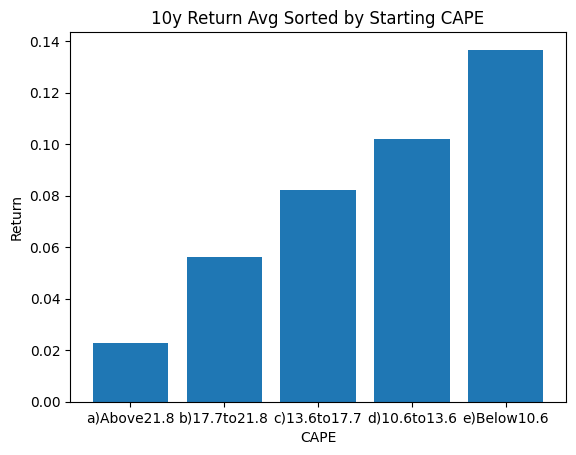

In [23]:
plt.bar(data_grouped_full.keys().tolist(), data_grouped_full.tolist())
plt.title('10y Return Avg Sorted by Starting CAPE')
plt.xlabel('CAPE')
plt.ylabel('Return')
plt.show()

In [24]:
data_grouped_roll_10y = data_bounded.groupby('CAPE_Bucket_Roll_Lagged_10y')['Return_10y'].mean()
data_grouped_roll_1y = data_bounded.groupby('CAPE_Bucket_Roll_Lagged_1y')['Return_1y'].mean()
data_grouped_roll_1m = data_bounded.groupby('CAPE_Bucket_Roll_Lagged_1m')['Return_1m'].mean()

In [25]:
data_grouped_roll = pd.concat([data_grouped_roll_10y, data_grouped_roll_1y, data_grouped_roll_1m], axis=1)
data_grouped_roll

,Return_10y,Return_1y,Return_1m
1.0,0.040130,0.035296,0.054459
2.0,0.089535,0.048485,0.059550
3.0,0.122748,0.069423,0.071380
4.0,0.114510,0.114090,0.064711
5.0,0.094377,0.099980,0.065129


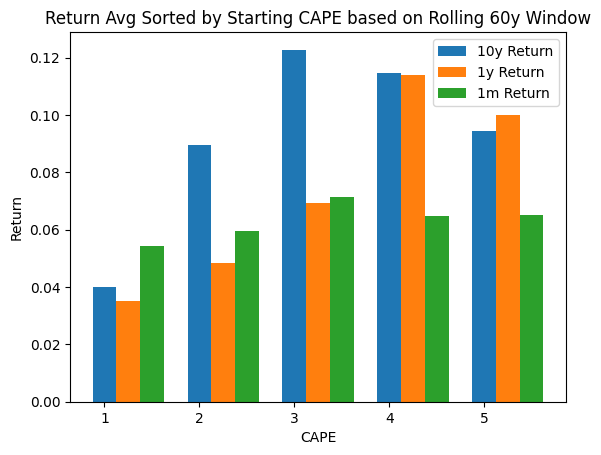

In [26]:
x = [1, 2, 3, 4, 5]
ret10y = data_grouped_roll['Return_10y'].tolist()
ret1y = data_grouped_roll['Return_1y'].tolist()
ret1m = data_grouped_roll['Return_1m'].tolist()

x_axis = np.arange(len(x))
width = 0.25

plt.bar(x_axis, ret10y, width = width, label = '10y Return')
plt.bar(x_axis + width, ret1y, width = width, label = '1y Return')
plt.bar(x_axis + width * 2, ret1m, width = width, label = '1m Return')

plt.xticks(x_axis, x)
plt.xlabel("CAPE")
plt.ylabel("Return")
plt.title("Return Avg Sorted by Starting CAPE based on Rolling 60y Window")
plt.legend()
plt.show()

### Regression

In [27]:
data_bounded['EP'] = 1 / data_bounded['CAPE']

In [28]:
data_bounded

,CAPE,DateMonth,Price,Return_10y,Return_1y,Return_1m,CAPE_Bucket_Full,CAPE_Bucket_Full_Lagged_10y,Perc_0.2_Roll,Perc_0.4_Roll,Perc_0.6_Roll,Perc_0.8_Roll,CAPE_Bucket_Roll,CAPE_Bucket_Roll_Lagged_10y,CAPE_Bucket_Roll_Lagged_1y,CAPE_Bucket_Roll_Lagged_1m,EP
348,18.67,1900-01-01,6.10,0.013383,0.003289,0.159468,b)17.7to21.8,c)13.6to17.7,15.276,16.306,17.130,18.204,1,2.0,1.0,1.0,0.053562
349,18.70,1900-02-01,6.21,0.016729,-0.015848,0.216393,b)17.7to21.8,c)13.6to17.7,15.278,16.318,17.130,18.222,1,2.0,1.0,1.0,0.053476
350,18.78,1900-03-01,6.26,0.018561,-0.021875,0.096618,b)17.7to21.8,c)13.6to17.7,15.280,16.330,17.130,18.270,1,2.0,1.0,1.0,0.053248
351,18.94,1900-04-01,6.34,0.017625,-0.021605,0.153355,b)17.7to21.8,c)13.6to17.7,15.292,16.342,17.166,18.342,1,1.0,1.0,1.0,0.052798
352,18.40,1900-05-01,6.04,0.007473,-0.027375,-0.567823,b)17.7to21.8,b)17.7to21.8,15.304,16.354,17.194,18.384,1,1.0,1.0,1.0,0.054348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,25.69,2015-08-01,2039.87,0.066619,0.039938,-0.310982,a)Above21.8,a)Above21.8,13.144,17.598,20.872,24.872,1,1.0,1.0,1.0,0.038926
1736,24.50,2015-09-01,1944.41,0.058608,-0.024493,-0.561565,a)Above21.8,a)Above21.8,13.144,17.598,20.894,24.872,2,1.0,1.0,1.0,0.040816
1737,25.49,2015-01-01,2024.81,0.069872,0.045187,0.496192,a)Above21.8,a)Above21.8,13.144,17.598,20.900,24.892,1,1.0,1.0,2.0,0.039231
1738,26.23,2015-11-01,2080.62,0.068149,0.017632,0.330757,a)Above21.8,a)Above21.8,13.144,17.598,20.904,24.944,1,1.0,1.0,1.0,0.038124


In [31]:
x = np.array(data_bounded['EP'])
y_10y = np.array(data_bounded['Return_10y'])
y_1y = np.array(data_bounded['Return_1y'])
y_1m = np.array(data_bounded['Return_1m'])

reg_10y_mod = sm.OLS(y_10y, x)
reg_10y = reg_10y_mod.fit()
print(reg_10y.summary())

reg_1y_mod = sm.OLS(y_1y, x)
reg_1y = reg_1y_mod.fit()
print(reg_1y.summary())

reg_1m_mod = sm.OLS(y_1m, x)
reg_1m = reg_1m_mod.fit()
print(reg_1m.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.210
Model:                            OLS   Adj. R-squared (uncentered):              0.209
Method:                 Least Squares   F-statistic:                              369.2
Date:                Sun, 11 Jun 2023   Prob (F-statistic):                    3.60e-73
Time:                        17:50:32   Log-Likelihood:                          1139.5
No. Observations:                1392   AIC:                                     -2277.
Df Residuals:                    1391   BIC:                                     -2272.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Data Processing

In [135]:
raw_dax = yf.download("^GDAXI", start='1988-02-01', end='2023-05-31', interval='1mo')
raw_dax

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1988-02-01,951.500000,1091.589966,951.500000,1083.339966,1083.339966,0
1988-03-01,1087.319946,1123.270020,1037.260010,1062.329956,1062.329956,0
1988-04-01,1063.280029,1102.329956,1049.170044,1049.170044,1049.170044,0
1988-05-01,1052.839966,1075.660034,994.349976,1075.660034,1075.660034,0
1988-06-01,1095.430054,1138.839966,1095.430054,1133.810059,1133.810059,0
...,...,...,...,...,...,...
2023-01-01,13992.709961,15269.709961,13976.440430,15128.269531,15128.269531,1263845700
2023-02-01,15125.120117,15658.559570,15107.830078,15365.139648,15365.139648,1321833900
2023-03-01,15399.910156,15706.370117,14458.389648,15628.839844,15628.839844,2329276000


In [136]:
raw_german_cape = pd.read_csv('Historic-cape-ratios.csv', index_col=False)
raw_german_cape

,Date,Germany
0,29/01/1982,9.76
1,26/02/1982,9.85
2,31/03/1982,10.13
3,30/04/1982,10.12
4,31/05/1982,9.55
...,...,...
492,31/01/2023,18.92
493,28/02/2023,18.94
494,31/03/2023,19.68
495,28/04/2023,20.03


In [137]:
def month_end(test_date):
    nxt_mnth = test_date.replace(day=28) + datetime.timedelta(days=4)
    res = nxt_mnth - datetime.timedelta(days=nxt_mnth.day)
    return res

In [138]:
data_german_cape = raw_german_cape
data_german_cape['DateFormat'] = data_german_cape.apply(lambda x: datetime.datetime.strptime(x['Date'], '%d/%m/%Y'), axis = 1).dt.date
data_german_cape['DateFormatEnd'] = data_german_cape.apply(lambda x: month_end(x['DateFormat']), axis=1)
data_german_cape = data_german_cape.drop(['Date','DateFormat'], axis=1)

In [139]:
data_dax = raw_dax
data_dax = data_dax[['Close']]
data_dax = data_dax.reset_index()
data_dax['DateFormat'] = data_dax['Date'].dt.date
data_dax['DateFormatShift'] = data_dax.apply(lambda x: x['Date'] - relativedelta(months=1), axis=1)
data_dax['DateFormatShiftEnd'] = data_dax.apply(lambda x: month_end(x['DateFormatShift']), axis=1)
data_dax['DateReformat'] = data_dax['DateFormatShiftEnd'].dt.date
data_dax = data_dax.drop(['Date', 'DateFormat', 'DateFormatShift', 'DateFormatShiftEnd'], axis=1)

In [140]:
data_germany = data_german_cape.merge(data_dax, how='left', left_on='DateFormatEnd', right_on='DateReformat')
data_germany = data_germany.drop(['DateReformat'], axis=1)
data_germany = data_germany.rename(columns={'Germany': 'CAPE', 'DateFormatEnd': 'Date', 'Close': 'Price'})

In [141]:
data_germany

,CAPE,Date,Price
0,9.76,1982-01-31,NaN
1,9.85,1982-02-28,NaN
2,10.13,1982-03-31,NaN
3,10.12,1982-04-30,NaN
4,9.55,1982-05-31,NaN
...,...,...,...
492,18.92,2023-01-31,15365.139648
493,18.94,2023-02-28,15628.839844
494,19.68,2023-03-31,15922.379883
495,20.03,2023-04-30,15664.019531


In [142]:
#data_germany.to_csv('data_germany.csv')

### Returns per CAPE Buckets

In [164]:
data_enhanced_ger = data_germany
data_enhanced_ger['Return_5y'] = data_enhanced_ger['Price'].pct_change(60)/5 # shorter time horizon
data_enhanced_ger['Return_1y'] = data_enhanced_ger['Price'].pct_change(12)
data_enhanced_ger['Return_1m'] = data_enhanced_ger['Price'].pct_change(1)*12

In [169]:
data_bounded_ger = data_enhanced_ger.loc[(data_enhanced_ger['Date'] >= datetime.date(1993, 1, 1)) & (data_enhanced_ger['Date'] <= datetime.date(2023, 4, 30))].copy() # later start than S&P

In [170]:
quantiles_full_ger = round(data_bounded_ger[['CAPE']].quantile([0.2, 0.4, 0.6, 0.8]), 1)
quantiles_full_ger

,CAPE
0.2,18.8
0.4,20.4
0.6,22.7
0.8,29.5


In [171]:
def quantiles_condition_ger(x):
    if x['CAPE'] > quantiles_full_ger['CAPE'][0.8]:
        return 'a)Above' + str(quantiles_full_ger['CAPE'][0.8])
    elif x['CAPE'] > quantiles_full_ger['CAPE'][0.6]:
        return 'b)' + str(quantiles_full_ger['CAPE'][0.6]) + 'to' + str(quantiles_full_ger['CAPE'][0.8])
    elif x['CAPE'] > quantiles_full_ger['CAPE'][0.4]:
        return 'c)' + str(quantiles_full_ger['CAPE'][0.4]) + 'to' + str(quantiles_full_ger['CAPE'][0.6])
    elif x['CAPE'] > quantiles_full_ger['CAPE'][0.2]:
        return 'd)' + str(quantiles_full_ger['CAPE'][0.2]) + 'to' + str(quantiles_full_ger['CAPE'][0.4])
    elif x['CAPE'] > 0:
        return 'e)' + 'Below' + str(quantiles_full_ger['CAPE'][0.2])
    else:
        return 'NA'

In [172]:
data_enhanced_ger['CAPE_Bucket_Full'] = data_enhanced_ger.apply(lambda x: quantiles_condition_ger(x), axis=1)

In [173]:
data_enhanced_ger['CAPE_Bucket_Full_Lagged_5y'] = data_enhanced_ger[['CAPE_Bucket_Full']].shift(60) #shorter lag at 5yrs

In [174]:
data_enhanced_ger['Perc_0.2_Roll'] = data_enhanced_ger[['CAPE']].rolling(240, min_periods=1).quantile(0.2) # shorter roll window 20yrs
data_enhanced_ger['Perc_0.4_Roll'] = data_enhanced_ger[['CAPE']].rolling(240, min_periods=1).quantile(0.4)
data_enhanced_ger['Perc_0.6_Roll'] = data_enhanced_ger[['CAPE']].rolling(240, min_periods=1).quantile(0.6)
data_enhanced_ger['Perc_0.8_Roll'] = data_enhanced_ger[['CAPE']].rolling(240, min_periods=1).quantile(0.8)

In [175]:
data_enhanced_ger['CAPE_Bucket_Roll'] = data_enhanced_ger.apply(lambda x: quantiles_roll_condition(x), axis=1)

In [176]:
data_enhanced_ger['CAPE_Bucket_Roll_Lagged_5y'] = data_enhanced_ger[['CAPE_Bucket_Roll']].shift(60) # shorter roll window 20yrs
data_enhanced_ger['CAPE_Bucket_Roll_Lagged_1y'] = data_enhanced_ger[['CAPE_Bucket_Roll']].shift(12)
data_enhanced_ger['CAPE_Bucket_Roll_Lagged_1m'] = data_enhanced_ger[['CAPE_Bucket_Roll']].shift(1)

In [177]:
data_bounded_ger = data_enhanced_ger.loc[(data_enhanced_ger['Date'] >= datetime.date(1993, 1, 1)) & (data_enhanced_ger['Date'] <= datetime.date(2023, 4, 30))].copy() # later start than S&P

In [153]:
#data_bounded_ger.to_csv('data_bounded_ger.csv')

In [178]:
data_grouped_full_ger = data_bounded_ger.groupby('CAPE_Bucket_Full_Lagged_5y')['Return_5y'].mean() # reduced to 5yrs

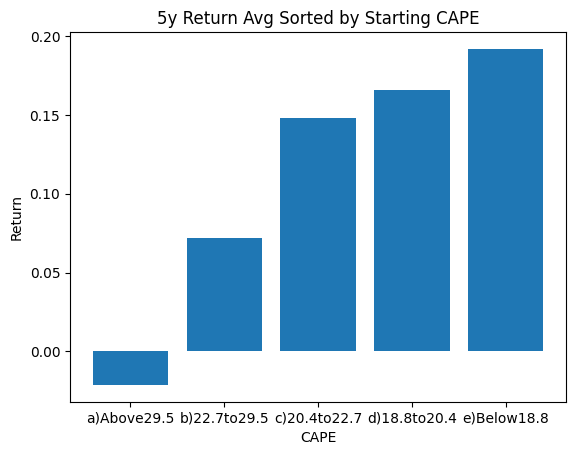

In [179]:
plt.bar(data_grouped_full_ger.keys().tolist(), data_grouped_full_ger.tolist())
plt.title('5y Return Avg Sorted by Starting CAPE')
plt.xlabel('CAPE')
plt.ylabel('Return')
plt.show()

In [180]:
data_grouped_roll_5y_ger = data_bounded_ger.groupby('CAPE_Bucket_Roll_Lagged_5y')['Return_5y'].mean()
data_grouped_roll_1y_ger = data_bounded_ger.groupby('CAPE_Bucket_Roll_Lagged_1y')['Return_1y'].mean()
data_grouped_roll_1m_ger = data_bounded_ger.groupby('CAPE_Bucket_Roll_Lagged_1m')['Return_1m'].mean()

In [181]:
data_grouped_roll_ger = pd.concat([data_grouped_roll_5y_ger, data_grouped_roll_1y_ger, data_grouped_roll_1m_ger], axis=1)
data_grouped_roll_ger

,Return_5y,Return_1y,Return_1m
1.0,0.046638,0.153267,0.136972
2.0,0.123713,0.004493,0.098740
3.0,0.127418,0.034382,-0.065489
4.0,0.131238,0.122403,0.039427
5.0,0.152657,0.217113,0.299647


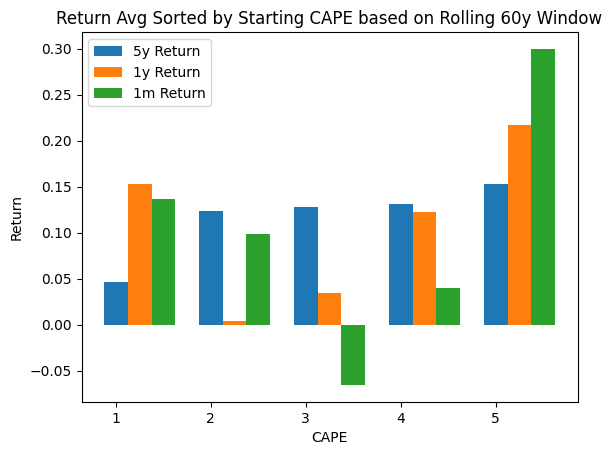

In [182]:
x = [1, 2, 3, 4, 5]
ret5y = data_grouped_roll_ger['Return_5y'].tolist() # shorter
ret1y = data_grouped_roll_ger['Return_1y'].tolist()
ret1m = data_grouped_roll_ger['Return_1m'].tolist()

x_axis = np.arange(len(x))
width = 0.25

plt.bar(x_axis, ret5y, width = width, label = '5y Return')
plt.bar(x_axis + width, ret1y, width = width, label = '1y Return')
plt.bar(x_axis + width * 2, ret1m, width = width, label = '1m Return')

plt.xticks(x_axis, x)
plt.xlabel("CAPE")
plt.ylabel("Return")
plt.title("Return Avg Sorted by Starting CAPE based on Rolling 60y Window")
plt.legend()
plt.show()

### Regression

In [183]:
data_bounded_ger['EP'] = 1 / data_bounded_ger['CAPE']

In [184]:
data_bounded_ger

,CAPE,Date,Price,Return_5y,Return_1y,Return_1m,CAPE_Bucket_Full,CAPE_Bucket_Full_Lagged_5y,Perc_0.2_Roll,Perc_0.4_Roll,Perc_0.6_Roll,Perc_0.8_Roll,CAPE_Bucket_Roll,CAPE_Bucket_Roll_Lagged_5y,CAPE_Bucket_Roll_Lagged_1y,CAPE_Bucket_Roll_Lagged_1m,EP
132,15.86,1993-01-31,1680.020020,0.110156,-0.038208,0.807959,e)Below18.8,e)Below18.8,13.784,16.042,18.554,21.174,4,4.0,2.0,4.0,0.063052
133,17.03,1993-02-28,1676.839966,0.115691,-0.024157,-0.022714,e)Below18.8,e)Below18.8,13.826,16.122,18.516,21.136,3,3.0,2.0,4.0,0.058720
134,16.90,1993-03-31,1626.829956,0.110118,-0.058596,-0.357888,e)Below18.8,e)Below18.8,13.868,16.206,18.468,21.098,3,3.0,2.0,3.0,0.059172
135,16.85,1993-04-30,1627.209961,0.102551,-0.099177,0.002803,e)Below18.8,e)Below18.8,13.910,16.290,18.420,21.060,3,3.0,2.0,3.0,0.059347
136,16.24,1993-05-31,1700.930054,0.100038,-0.030781,0.543655,e)Below18.8,e)Below18.8,13.912,16.260,18.408,21.054,4,3.0,2.0,3.0,0.061576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,17.22,2022-12-31,15128.269531,0.029399,-0.022166,1.038249,e)Below18.8,c)20.4to22.7,18.292,19.706,21.424,23.860,5,3.0,3.0,4.0,0.058072
492,18.92,2023-01-31,15365.139648,0.047110,0.062521,0.187889,d)18.8to20.4,b)22.7to29.5,18.326,19.706,21.424,23.860,4,3.0,3.0,5.0,0.052854
493,18.94,2023-02-28,15628.839844,0.058398,0.084226,0.205947,d)18.8to20.4,c)20.4to22.7,18.386,19.706,21.424,23.860,4,3.0,4.0,4.0,0.052798
494,19.68,2023-03-31,15922.379883,0.052494,0.129417,0.225383,d)18.8to20.4,c)20.4to22.7,18.424,19.706,21.424,23.860,4,3.0,4.0,4.0,0.050813


In [185]:
#data_bounded_ger.to_csv('data_bounded_ger.csv')

In [186]:
x = np.array(data_bounded_ger['EP'])
y_5y = np.array(data_bounded_ger['Return_5y'])
y_1y = np.array(data_bounded_ger['Return_1y'])
y_1m = np.array(data_bounded_ger['Return_1m'])

reg_5y_mod = sm.OLS(y_5y, x)
reg_5y = reg_5y_mod.fit()
print(reg_5y.summary())

reg_1y_mod = sm.OLS(y_1y, x)
reg_1y = reg_1y_mod.fit()
print(reg_1y.summary())

reg_1m_mod = sm.OLS(y_1m, x)
reg_1m = reg_1m_mod.fit()
print(reg_1m.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.247
Model:                            OLS   Adj. R-squared (uncentered):              0.245
Method:                 Least Squares   F-statistic:                              119.2
Date:                Sun, 11 Jun 2023   Prob (F-statistic):                    3.46e-24
Time:                        20:16:21   Log-Likelihood:                          174.18
No. Observations:                 364   AIC:                                     -346.4
Df Residuals:                     363   BIC:                                     -342.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------